# Rotating MNIST dataset

In [2]:
import os
import jax
import optax
import dojax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from augly import image
from multiprocessing import Pool

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

In [4]:
cpu_count = os.cpu_count()
print(f"Number of cores: {cpu_count}")

Number of cores: 96


In [5]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [6]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [7]:
def img_resize_28x28(img):
    size_im = img.shape[0]
    size_pad = (28 - size_im) // 2
    size_pad_mod = (28 - size_im) % 2

    return np.pad(img, (size_pad, size_pad + size_pad_mod))

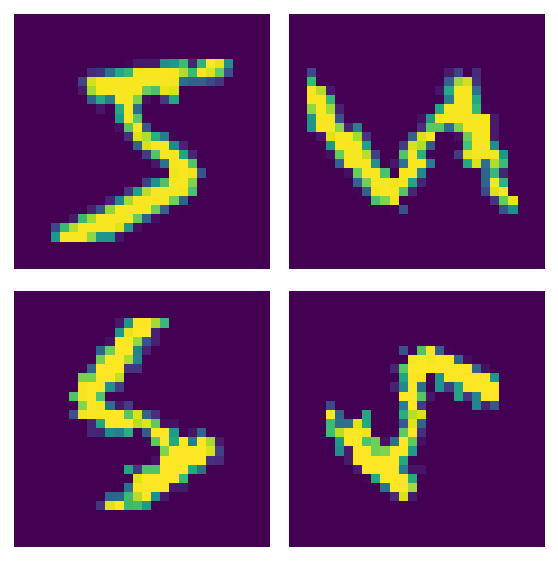

In [8]:
radii = [1, 180 * jnp.pi / 2, 180 * jnp.pi, 180 * 3 * jnp.pi / 2]
X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for axi, deg in zip(ax.flat, radii):
    x_shift = image.aug_np_wrapper(X_train[0], image.rotate, degrees=deg)
    x_shift = img_resize_28x28(x_shift)
    
    
    axi.imshow(x_shift)
    axi.axis("off")
plt.tight_layout()

In [9]:
class RotateDeg:
    def __init__(self, deg):
        self.deg = deg
        
    def __call__(self, img):
        return self.rotate_multiple(img)

    def rotate(self, X):
        """
        Rotate an image using the augly library

        Paramters
        ---------
        X: np.array
            A single NxM-dimensional array
        """
        new_image = image.aug_np_wrapper(X, image.rotate, degrees=self.deg)
        new_image = img_resize_28x28(new_image)
        return new_image

    def rotate_multiple(self, X_batch):
        images_out = []
        for X in X_batch:
            img_rotate = self.rotate(X)
            images_out.append(img_rotate)
        images_out = np.stack(images_out, axis=0)
        return images_out

## Estimating weights

In [10]:
def make_loss_func(model, X, y):
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = optax.softmax_cross_entropy(pred, y).mean()
        return loss
    return loss_fn
    # return jax.jit(loss_fn) # assuming top-levelled funciton is not jitted


class MLPWide(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(800)(x))
        x = nn.relu(nn.Dense(500, name="last_layer")(x))
        x = nn.Dense(self.num_outputs)(x)
        x = nn.log_softmax(x)
        return x

    
def print_progress(epoch, loss, step_mod):
    if epoch % step_mod == 0:
        print(f"Loss step ({epoch}: {loss:0.4e})")


@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func(model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step


def proc_dataset(deg, img_dataset, n_processes=90):
    """
    Rotate all images of a dataset stored in a numpy array.
    
    Parameters
    ----------
    radius: float
        Intensity of bluriness
    img_dataset: array(N, L, K)
        N images of size LxK
    n_processes: int
        Number of processes to blur over
    """
    pool = Pool(processes=n_processes)
    
    dataset_proc = np.array_split(img_dataset, n_processes)
    dataset_proc = pool.map(RotateDeg(deg), dataset_proc)
    dataset_proc = np.concatenate(dataset_proc, axis=0)
    
    pool.close()
    
    return dataset_proc

In [11]:
key = jax.random.PRNGKey(314)

alpha = 0.001
n_classes = 10
n_subset = 5000
batch_size = 2_000
n_epochs = 150
tx = optax.adam(learning_rate=alpha)

model = MLPWide(n_classes)
# X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
# y_train_ohe = jax.nn.one_hot(y_train, n_classes)


def train_model_config(key, deg, num_epochs):
    X_train_proc = proc_dataset(deg, X_train, 90)
    X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
    y_train_ohe = jax.nn.one_hot(y_train, n_classes)

    batch = jnp.ones((1, 28 ** 2))
    params = model.init(key, batch)
    opt_state = tx.init(params)

    for e in range(num_epochs):
        print(f"@epoch {e+1:03}", end="\r")
        _, key = jax.random.split(key)
        params, opt_state = train_epoch(key, params, opt_state, X_train_ravel, y_train_ohe, batch_size, e)

    final_train_acc = (y_train == model.apply(params, X_train_ravel).argmax(axis=1)).mean().item()
    print(f"@{deg=:0.2f}, {final_train_acc=:0.4f}")
    
    return params, final_train_acc

In [ ]:
hist_params = []
hist_accuracy = []

degrees = jnp.linspace(1, 2 * 360, 200)

time_start = time()
for deg in degrees:
    deg = deg.item()
    params, train_acc = train_model_config(key, deg, n_epochs)
    
    hist_accuracy.append(train_acc)
    hist_params.append(params)

hist_accuracy = jnp.array(hist_accuracy)
time_end = time()
time_total = time_end - time_start

print(f"Total running time: {time_total:0.2f}s")

In [ ]:
hist_params_flat = dojax.flat_and_concat_params(hist_params)
jnp.save("mnist_rotate_params.npy", hist_params_flat)

In [86]:
# proj = PCA(n_components=2)
proj = TSNE(n_components=2, init="pca", random_state=314,
            perplexity=20, learning_rate="auto")
params_proj = proj.fit_transform(hist_params_flat)

/home/gerardoduran/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0, 0.5, 'Accuracy')

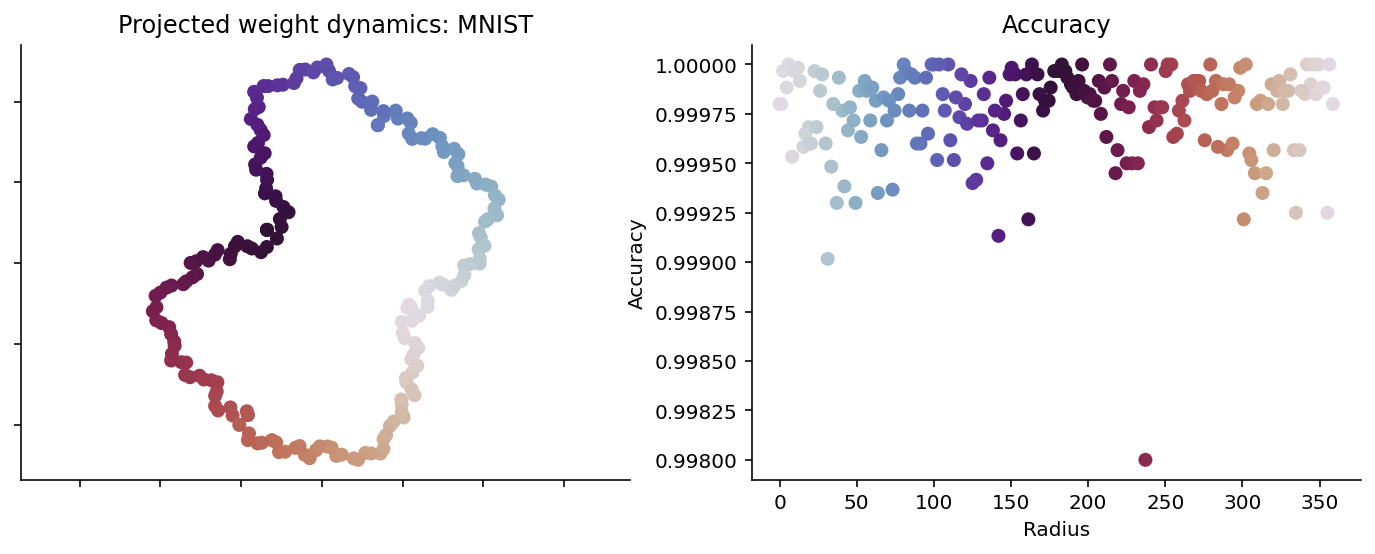

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
ax[0].scatter(*params_proj.T, c=degrees % 360, cmap="twilight")
# ax[0].cb(label="radius")
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")

ax[1].set_title("Accuracy")
ax[1].scatter(degrees % 360, hist_accuracy, c=degrees % 360, cmap="twilight")
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy")